## Exercise: Using DCGAN to Generate Handwritten Digits (Paper Reference)

In [1]:
import os, tensorflow as tf
print(tf.__version__)

2.10.1


In [2]:
import os, random, numpy as np
from numpy import expand_dims, vstack, zeros, ones
from numpy.random import randn, randint
import tensorflow as tf
from tensorflow.keras.initializers import RandomNormal
from keras.datasets.mnist import load_data
from keras.optimizers import Adam
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Reshape, Flatten, Conv2D
from keras.layers import Conv2DTranspose, ReLU, LeakyReLU, Dropout
from keras.layers import UpSampling2D, BatchNormalization
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

In [3]:
def set_seed(seed_value=1234):
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)

seed_value = 1234
set_seed(seed_value)

### Load Images

In [4]:
# load the images into memory
(train_images, train_labels), (_, _) = load_data()

# summarize the shape of the dataset
print('Size', train_images.shape, train_labels.shape)

Size (60000, 28, 28) (60000,)


### Preprocessing

In [5]:
# Reshape data and also convert the data type to 'float32'
print(train_images.shape)
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
print(train_images.shape)

# Normalize the images to [-1, 1] which is the range of the tanh activation
train_images = (train_images - 127.5) / 127.5

(60000, 28, 28)
(60000, 28, 28, 1)


## The generator model

the generator model is responsible for generating new synthetic data samples that resemble the training data. It is a deep convolutional neural network (CNN) architecture that takes random noise as input and produces output that resembles the original data distribution.

In [6]:
def build_generator(latent_size=100, alpha=0.2):
    weight_init = RandomNormal(mean=0.0, stddev=0.02)
    model = Sequential(name='generator')

    model.add(Dense(7 * 7 * 128, input_dim=latent_size, kernel_initializer=weight_init))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha))
    model.add(Reshape((7, 7, 128)))

    model.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same',
                              kernel_initializer=weight_init))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha))

    model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same',
                              kernel_initializer=weight_init))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha))

    model.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same',
                              activation='tanh', kernel_initializer=weight_init))
    return model

## The discriminator model

The discriminator model takes an input image and processes it through a series of convolutional layers, followed by activation functions such as LeakyReLU, and pooling layers. This helps extract features and learn representations from the input image. The final output of the discriminator is a probability score indicating the likelihood that the input image is real or fake.

In [7]:
def build_discriminator(input_shape=(28, 28, 1), alpha=0.2):
    weight_init = RandomNormal(mean=0.0, stddev=0.02)
    model = Sequential(name='discriminator')

    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                     input_shape=input_shape, kernel_initializer=weight_init))
    model.add(LeakyReLU(alpha))

    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same',
                     kernel_initializer=weight_init))
    model.add(LeakyReLU(alpha))

    model.add(Flatten())
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    return model

## Train the DCGAN model

In [8]:
latent_size = 100

# Build and compile the discriminator
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(learning_rate=0.0002, beta_1=0.5),
                      metrics=['accuracy'])

# Build the generator
generator = build_generator(latent_size)

# Build and compile the GAN
discriminator.trainable = False  # Freeze the discriminator's weights when training the generator
gan_input = Input(shape=(latent_size,))
gan_output = discriminator(generator(gan_input))
gan = Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))

gan.summary()

c:\Users\ASUS\anaconda3\envs\dl_env\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 generator (Sequential)      (None, 28, 28, 1)         1275521   
                                                                 
 discriminator (Sequential)  (None, 1)                 212865    
                                                                 
Total params: 1,488,386
Trainable params: 1,262,593
Non-trainable params: 225,793
_________________________________________________________________


Epoch 1/100
Step 0/937 [D loss: 0.6923, acc.: 0.00%] [G loss: 0.6772]
Step 100/937 [D loss: 0.3411, acc.: 0.00%] [G loss: 0.0445]
Step 200/937 [D loss: 0.3481, acc.: 0.00%] [G loss: 0.0261]
Step 300/937 [D loss: 0.3607, acc.: 0.00%] [G loss: 0.5130]
Step 400/937 [D loss: 0.6727, acc.: 0.00%] [G loss: 0.7461]
Step 500/937 [D loss: 0.6640, acc.: 0.00%] [G loss: 0.8348]
Step 600/937 [D loss: 0.7375, acc.: 0.00%] [G loss: 0.6230]
Step 700/937 [D loss: 0.6684, acc.: 0.00%] [G loss: 0.7724]
Step 800/937 [D loss: 0.7144, acc.: 0.00%] [G loss: 0.7093]
Step 900/937 [D loss: 0.7343, acc.: 0.00%] [G loss: 0.6750]
1/1 [==============================] - 0s 310ms/step


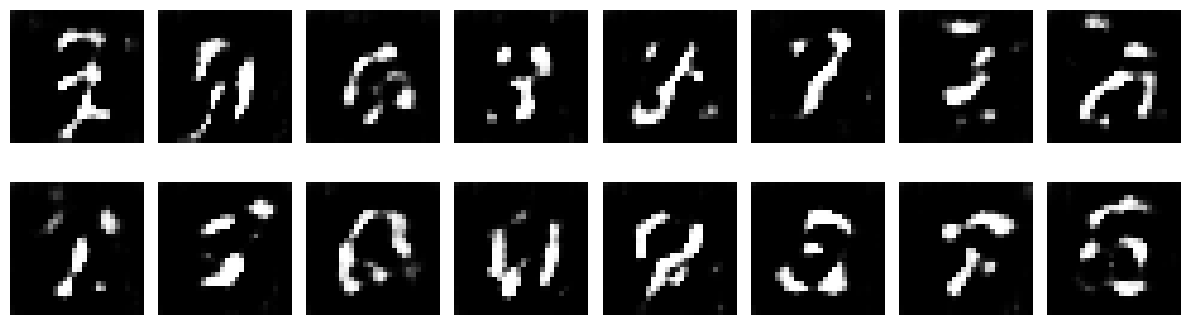

Epoch 2/100
Step 0/937 [D loss: 0.6607, acc.: 0.00%] [G loss: 0.7929]
Step 100/937 [D loss: 0.7044, acc.: 0.00%] [G loss: 0.7626]
Step 200/937 [D loss: 0.6607, acc.: 0.00%] [G loss: 0.7757]
Step 300/937 [D loss: 0.6872, acc.: 0.00%] [G loss: 0.7707]
Step 400/937 [D loss: 0.7219, acc.: 0.00%] [G loss: 0.7284]
Step 500/937 [D loss: 0.6597, acc.: 0.00%] [G loss: 0.8251]
Step 600/937 [D loss: 0.7023, acc.: 0.00%] [G loss: 0.7299]
Step 700/937 [D loss: 0.7288, acc.: 0.00%] [G loss: 0.7158]
Step 800/937 [D loss: 0.6651, acc.: 0.00%] [G loss: 0.7531]
Step 900/937 [D loss: 0.6654, acc.: 0.00%] [G loss: 0.7561]
1/1 [==============================] - 0s 28ms/step


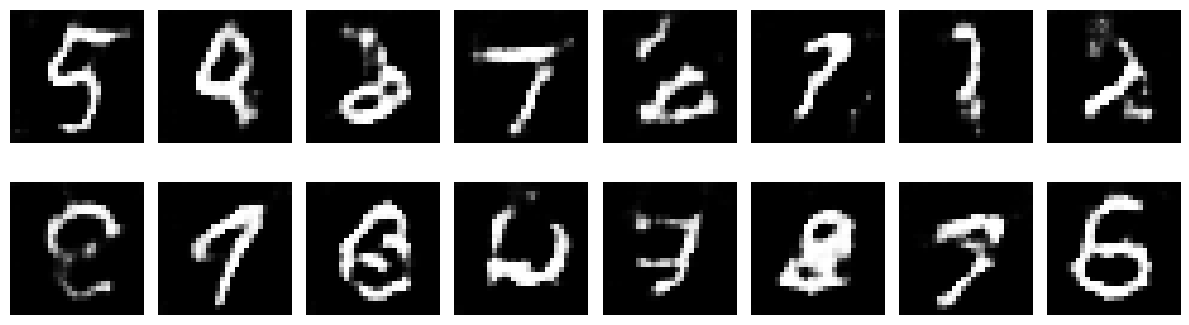

Epoch 3/100
Step 0/937 [D loss: 0.6964, acc.: 0.00%] [G loss: 0.7425]
Step 100/937 [D loss: 0.6749, acc.: 0.00%] [G loss: 0.7772]
Step 200/937 [D loss: 0.6791, acc.: 0.00%] [G loss: 0.7378]
Step 300/937 [D loss: 0.6801, acc.: 0.00%] [G loss: 0.7824]
Step 400/937 [D loss: 0.7110, acc.: 0.00%] [G loss: 0.6849]
Step 500/937 [D loss: 0.6719, acc.: 0.00%] [G loss: 0.7445]
Step 600/937 [D loss: 0.6922, acc.: 0.00%] [G loss: 0.7315]
Step 700/937 [D loss: 0.6885, acc.: 0.00%] [G loss: 0.7469]
Step 800/937 [D loss: 0.6628, acc.: 0.00%] [G loss: 0.8091]
Step 900/937 [D loss: 0.6710, acc.: 0.00%] [G loss: 0.8332]
1/1 [==============================] - 0s 25ms/step


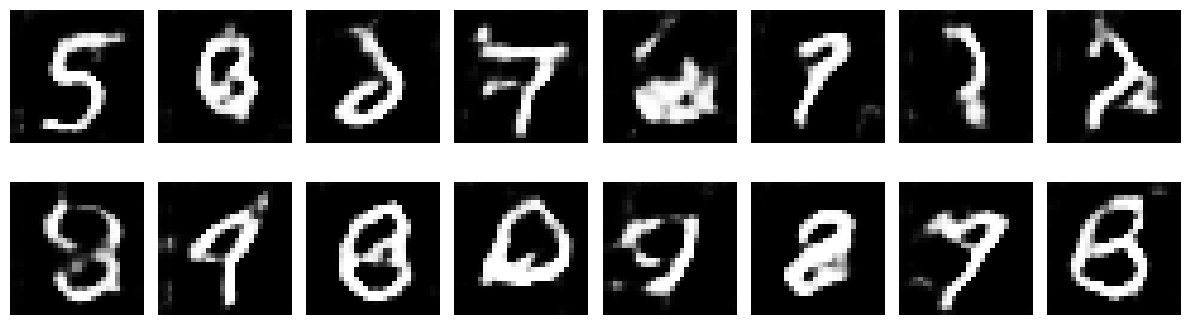

Epoch 4/100
Step 0/937 [D loss: 0.6851, acc.: 0.00%] [G loss: 0.7651]
Step 100/937 [D loss: 0.6955, acc.: 0.00%] [G loss: 0.7732]
Step 200/937 [D loss: 0.6926, acc.: 0.00%] [G loss: 0.7509]
Step 300/937 [D loss: 0.6853, acc.: 0.00%] [G loss: 0.7159]
Step 400/937 [D loss: 0.7034, acc.: 0.00%] [G loss: 0.7456]
Step 500/937 [D loss: 0.6876, acc.: 0.00%] [G loss: 0.7333]
Step 600/937 [D loss: 0.7015, acc.: 0.00%] [G loss: 0.7351]
Step 700/937 [D loss: 0.6788, acc.: 0.00%] [G loss: 0.7696]
Step 800/937 [D loss: 0.6878, acc.: 0.00%] [G loss: 0.7644]
Step 900/937 [D loss: 0.6888, acc.: 0.00%] [G loss: 0.7784]
1/1 [==============================] - 0s 31ms/step


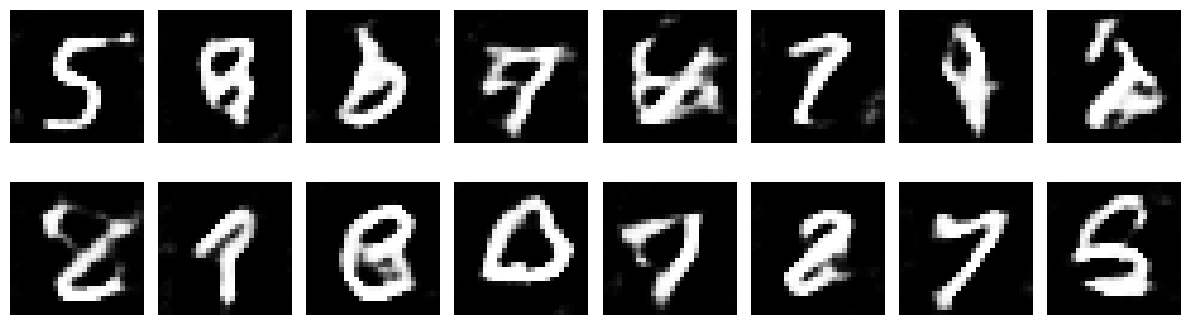

Epoch 5/100
Step 0/937 [D loss: 0.6743, acc.: 0.00%] [G loss: 0.7920]
Step 100/937 [D loss: 0.6801, acc.: 0.00%] [G loss: 0.7883]
Step 200/937 [D loss: 0.6870, acc.: 0.00%] [G loss: 0.7495]
Step 300/937 [D loss: 0.6818, acc.: 0.00%] [G loss: 0.7911]
Step 400/937 [D loss: 0.6775, acc.: 0.00%] [G loss: 0.7779]
Step 500/937 [D loss: 0.6808, acc.: 0.00%] [G loss: 0.7703]
Step 600/937 [D loss: 0.6736, acc.: 0.00%] [G loss: 0.7887]
Step 700/937 [D loss: 0.6711, acc.: 0.00%] [G loss: 0.7725]
Step 800/937 [D loss: 0.6694, acc.: 0.00%] [G loss: 0.7802]
Step 900/937 [D loss: 0.6635, acc.: 0.00%] [G loss: 0.7641]
1/1 [==============================] - 0s 33ms/step


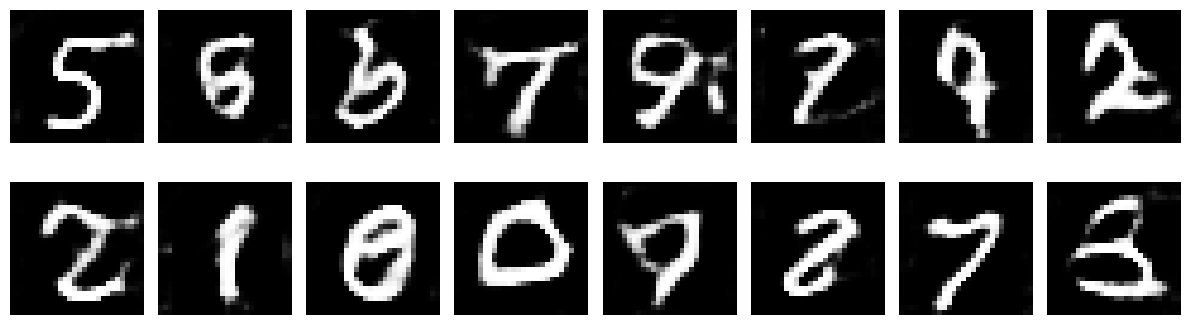

Epoch 6/100
Step 0/937 [D loss: 0.6861, acc.: 0.00%] [G loss: 0.7915]
Step 100/937 [D loss: 0.6774, acc.: 0.00%] [G loss: 0.7836]
Step 200/937 [D loss: 0.6983, acc.: 0.00%] [G loss: 0.7696]
Step 300/937 [D loss: 0.6827, acc.: 0.00%] [G loss: 0.7628]
Step 400/937 [D loss: 0.6721, acc.: 0.00%] [G loss: 0.7974]
Step 500/937 [D loss: 0.6725, acc.: 0.00%] [G loss: 0.7941]
Step 600/937 [D loss: 0.6906, acc.: 0.00%] [G loss: 0.7656]
Step 700/937 [D loss: 0.6849, acc.: 0.00%] [G loss: 0.8108]
Step 800/937 [D loss: 0.6720, acc.: 0.00%] [G loss: 0.8272]
Step 900/937 [D loss: 0.6768, acc.: 0.00%] [G loss: 0.7723]
1/1 [==============================] - 0s 28ms/step


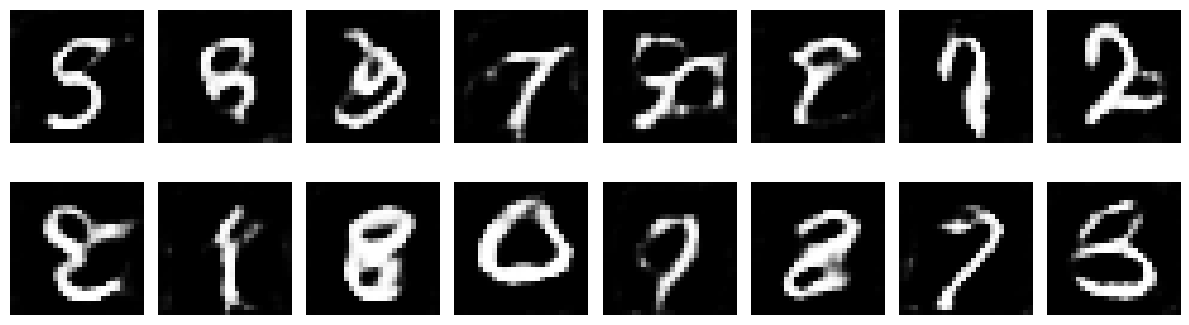

Epoch 7/100
Step 0/937 [D loss: 0.6507, acc.: 0.00%] [G loss: 0.8418]
Step 100/937 [D loss: 0.6738, acc.: 0.00%] [G loss: 0.8140]
Step 200/937 [D loss: 0.7007, acc.: 0.00%] [G loss: 0.7480]
Step 300/937 [D loss: 0.6587, acc.: 0.00%] [G loss: 0.8115]
Step 400/937 [D loss: 0.6742, acc.: 0.00%] [G loss: 0.7786]
Step 500/937 [D loss: 0.6879, acc.: 0.00%] [G loss: 0.7892]
Step 600/937 [D loss: 0.6862, acc.: 0.00%] [G loss: 0.7893]
Step 700/937 [D loss: 0.6649, acc.: 0.00%] [G loss: 0.8379]
Step 800/937 [D loss: 0.6760, acc.: 0.00%] [G loss: 0.7758]
Step 900/937 [D loss: 0.6696, acc.: 0.00%] [G loss: 0.7693]
1/1 [==============================] - 0s 31ms/step


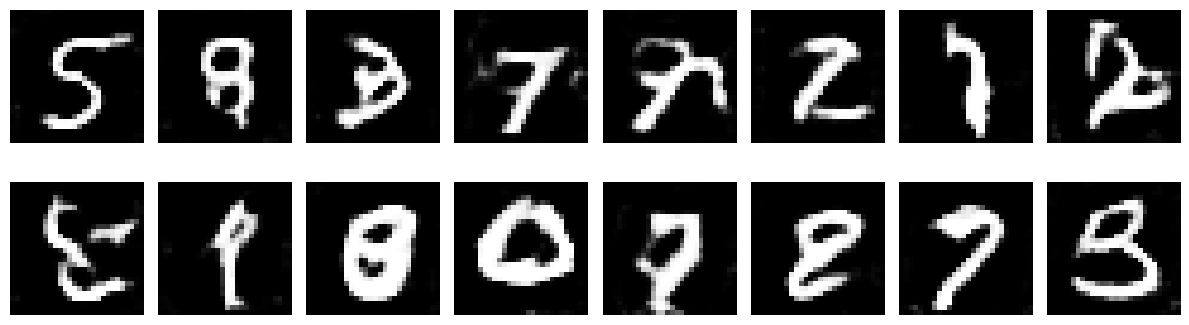

Epoch 8/100
Step 0/937 [D loss: 0.6697, acc.: 0.00%] [G loss: 0.8164]
Step 100/937 [D loss: 0.6826, acc.: 0.00%] [G loss: 0.8255]
Step 200/937 [D loss: 0.6724, acc.: 0.00%] [G loss: 0.7924]
Step 300/937 [D loss: 0.6846, acc.: 0.00%] [G loss: 0.7828]
Step 400/937 [D loss: 0.6928, acc.: 0.00%] [G loss: 0.7664]
Step 500/937 [D loss: 0.6787, acc.: 0.00%] [G loss: 0.7954]
Step 600/937 [D loss: 0.6923, acc.: 0.00%] [G loss: 0.7989]
Step 700/937 [D loss: 0.6740, acc.: 0.00%] [G loss: 0.8190]
Step 800/937 [D loss: 0.6720, acc.: 0.00%] [G loss: 0.8155]
Step 900/937 [D loss: 0.6597, acc.: 0.00%] [G loss: 0.7787]
1/1 [==============================] - 0s 31ms/step


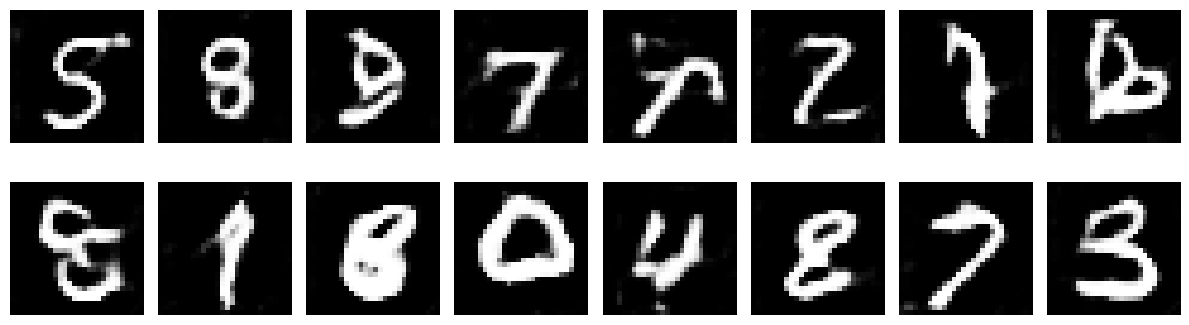

Epoch 9/100
Step 0/937 [D loss: 0.6596, acc.: 0.00%] [G loss: 0.8328]
Step 100/937 [D loss: 0.6755, acc.: 0.00%] [G loss: 0.8235]
Step 200/937 [D loss: 0.6839, acc.: 0.00%] [G loss: 0.7741]
Step 300/937 [D loss: 0.6843, acc.: 0.00%] [G loss: 0.8071]
Step 400/937 [D loss: 0.6710, acc.: 0.00%] [G loss: 0.7973]
Step 500/937 [D loss: 0.6777, acc.: 0.00%] [G loss: 0.8344]
Step 600/937 [D loss: 0.6667, acc.: 0.00%] [G loss: 0.7705]
Step 700/937 [D loss: 0.6789, acc.: 0.00%] [G loss: 0.8085]
Step 800/937 [D loss: 0.6710, acc.: 0.00%] [G loss: 0.8133]
Step 900/937 [D loss: 0.6641, acc.: 0.00%] [G loss: 0.7948]
1/1 [==============================] - 0s 31ms/step


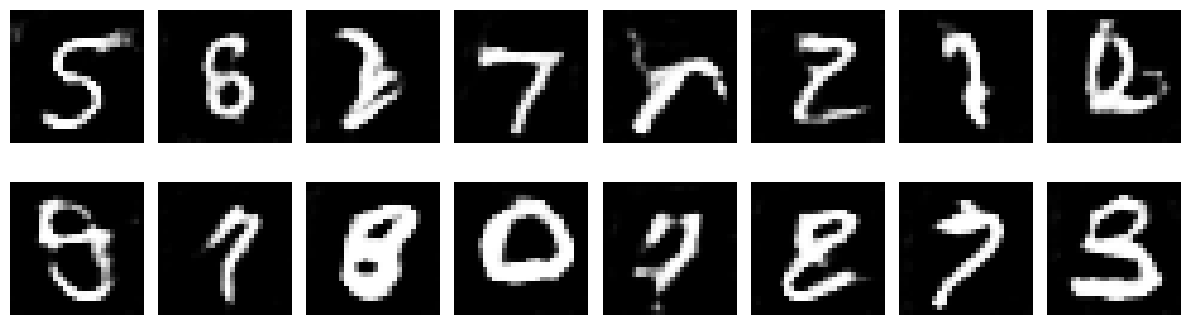

Epoch 10/100
Step 0/937 [D loss: 0.6895, acc.: 0.00%] [G loss: 0.8071]
Step 100/937 [D loss: 0.6787, acc.: 0.00%] [G loss: 0.8023]
Step 200/937 [D loss: 0.6728, acc.: 0.00%] [G loss: 0.8088]
Step 300/937 [D loss: 0.6601, acc.: 0.00%] [G loss: 0.7737]
Step 400/937 [D loss: 0.6784, acc.: 0.00%] [G loss: 0.8005]
Step 500/937 [D loss: 0.6727, acc.: 0.00%] [G loss: 0.7989]
Step 600/937 [D loss: 0.6815, acc.: 0.00%] [G loss: 0.7976]
Step 700/937 [D loss: 0.6911, acc.: 0.00%] [G loss: 0.8026]
Step 800/937 [D loss: 0.6820, acc.: 0.00%] [G loss: 0.7829]
Step 900/937 [D loss: 0.6673, acc.: 0.00%] [G loss: 0.8285]
1/1 [==============================] - 0s 30ms/step


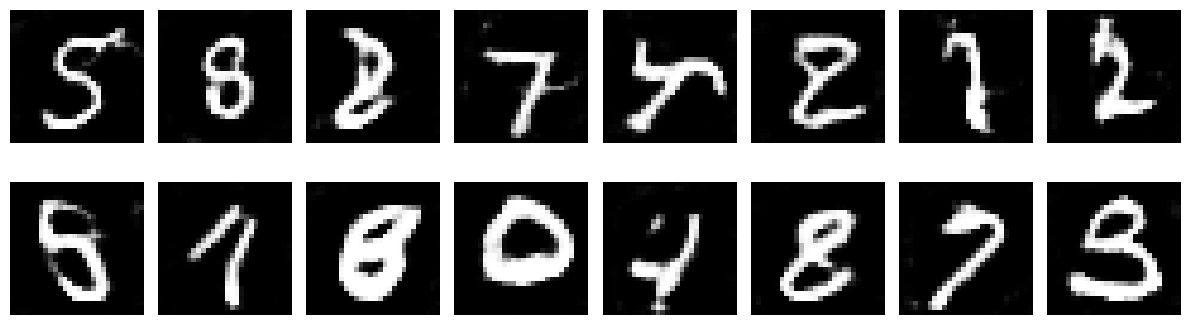

Epoch 11/100
Step 0/937 [D loss: 0.6869, acc.: 0.00%] [G loss: 0.8134]
Step 100/937 [D loss: 0.6866, acc.: 0.00%] [G loss: 0.7771]
Step 200/937 [D loss: 0.6716, acc.: 0.00%] [G loss: 0.8190]
Step 300/937 [D loss: 0.6621, acc.: 0.00%] [G loss: 0.8361]
Step 400/937 [D loss: 0.6732, acc.: 0.00%] [G loss: 0.7870]
Step 500/937 [D loss: 0.6739, acc.: 0.00%] [G loss: 0.7974]
Step 600/937 [D loss: 0.6717, acc.: 0.00%] [G loss: 0.8041]
Step 700/937 [D loss: 0.6705, acc.: 0.00%] [G loss: 0.7899]
Step 800/937 [D loss: 0.6823, acc.: 0.00%] [G loss: 0.8214]
Step 900/937 [D loss: 0.6946, acc.: 0.00%] [G loss: 0.8023]
1/1 [==============================] - 0s 33ms/step


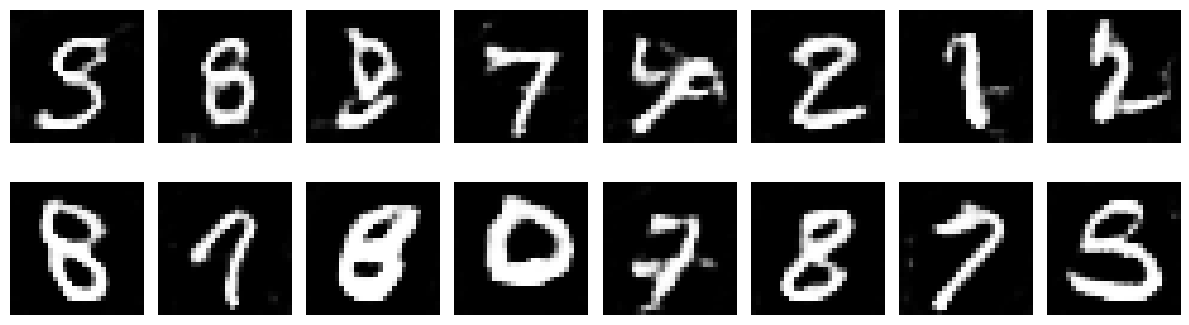

Epoch 12/100
Step 0/937 [D loss: 0.6844, acc.: 0.00%] [G loss: 0.8130]
Step 100/937 [D loss: 0.6567, acc.: 0.00%] [G loss: 0.8596]
Step 200/937 [D loss: 0.6806, acc.: 0.00%] [G loss: 0.8485]
Step 300/937 [D loss: 0.6884, acc.: 0.00%] [G loss: 0.7840]
Step 400/937 [D loss: 0.6771, acc.: 0.00%] [G loss: 0.8128]
Step 500/937 [D loss: 0.6673, acc.: 0.00%] [G loss: 0.8331]
Step 600/937 [D loss: 0.6912, acc.: 0.00%] [G loss: 0.7934]
Step 700/937 [D loss: 0.6741, acc.: 0.00%] [G loss: 0.8142]
Step 800/937 [D loss: 0.6651, acc.: 0.00%] [G loss: 0.7599]
Step 900/937 [D loss: 0.6874, acc.: 0.00%] [G loss: 0.7782]
1/1 [==============================] - 0s 33ms/step


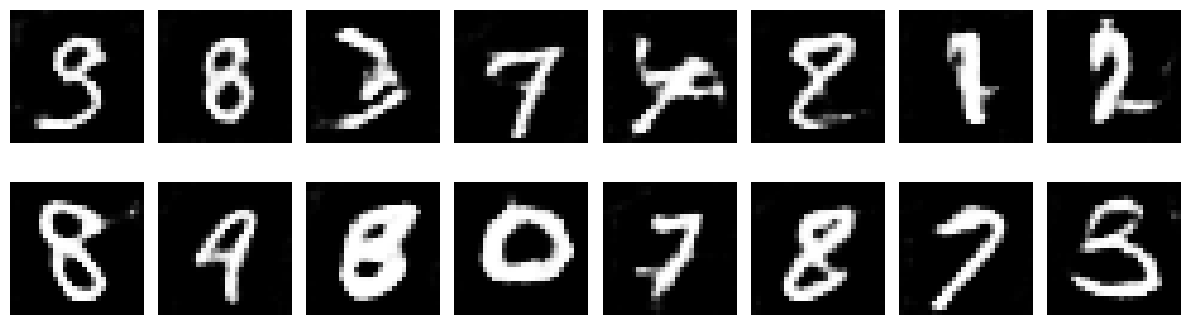

Epoch 13/100
Step 0/937 [D loss: 0.6614, acc.: 0.00%] [G loss: 0.8261]
Step 100/937 [D loss: 0.6635, acc.: 0.00%] [G loss: 0.8555]
Step 200/937 [D loss: 0.6704, acc.: 0.00%] [G loss: 0.8308]
Step 300/937 [D loss: 0.6620, acc.: 0.00%] [G loss: 0.8030]


KeyboardInterrupt: 

In [9]:
epochs = 100  # Increase the number of epochs
batch_size = 64
steps_per_epoch = train_images.shape[0] // batch_size
num_gen_images = 16
fixed_noise = np.random.normal(0, 1, (num_gen_images, latent_size))

for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}')
    for i in range(steps_per_epoch):
        # ---------------------
        #  Train Discriminator
        # ---------------------
        discriminator.trainable = True

        # Sample real images
        idx = np.random.randint(0, train_images.shape[0], batch_size)
        real_images = train_images[idx]

        # Generate fake images
        noise = np.random.normal(0, 1, (batch_size, latent_size))
        fake_images = generator.predict(noise, verbose=0)

        # Labels for real and fake images
        real_labels = np.ones((batch_size, 1)) * 0.9  # Label smoothing
        fake_labels = np.zeros((batch_size, 1)) + 0.1

        # Train the discriminator
        d_loss_real = discriminator.train_on_batch(real_images, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train Generator
        # ---------------------
        discriminator.trainable = False

        # Train the generator (to have the discriminator label samples as valid)
        noise = np.random.normal(0, 1, (batch_size, latent_size))
        valid_labels = np.ones((batch_size, 1))
        g_loss = gan.train_on_batch(noise, valid_labels)

        # Print the progress
        if i % 100 == 0:
            print(f"Step {i}/{steps_per_epoch} [D loss: {d_loss[0]:.4f}, acc.: {100*d_loss[1]:.2f}%] [G loss: {g_loss:.4f}]")

    # Generate images to monitor progress
    gen_images = generator.predict(fixed_noise)
    gen_images = 0.5 * gen_images + 0.5  # Rescale to [0,1]

    fig, axes = plt.subplots(2, 8, figsize=(12, 4))
    axes = axes.flatten()
    for img, ax in zip(gen_images, axes):
        ax.imshow(img.reshape(28, 28), cmap='gray')
        ax.axis('off')
    plt.tight_layout()
    plt.show()